<a href="https://colab.research.google.com/github/roguxivlo/machine-learning-24L/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Analyzing and Plotting Bias in Penalized Regression**

-------------------------------

In this assignment, you will explore how **Ridge** and **Lasso** regression introduce **bias** into a model to reduce **variance**, and how the choice of the regularization parameter $\lambda$ affects this trade-off. The goal is to visualize and analyze the **bias-variance trade-off** and understand the conditions under which penalization helps or hinders model performance.

## **The Question**

**How does varying the regularization parameter $\lambda$ in Ridge and Lasso regression impact the trade-off between bias and variance?**

- :white_check_mark: Generate a synthetic dataset based on a **known** linear relationship:
  
  $$
  y = \beta_0 + \beta_1 x + \ldots + \epsilon
  $$

  where $$\epsilon \sim \mathcal{N}(0, \sigma^2),$$

  use a **high-dimensional** setting (e.g., 50 predictors) with only a few non-zero true coefficients to emphasize the effects of regularization. I stress, the $\beta_i$ coefficients should be known for this experiment and they should be mostly 0, with only a few non-zero parameters.

- :white_check_mark: Investigate how increasing $\lambda$ influences the model’s **bias**, **variance**, and **Mean Squared Error (MSE)**.
- :white_check_mark: Plot **Bias²**, **Variance**, and **MSE** on a single graph for both Ridge and Lasso models.
- :white_check_mark: Explain MSE decomposition into bias and variance. Read more on the MSE decomposition if you need to.

**Does the regularization lead to an optimal trade-off point where MSE is minimized? Explain why this point exists.**




**Expected Outcome:**
 - As $\lambda$ increases:
   - **Bias** increases (the model becomes too simple).
   - **Variance** decreases (the model becomes more stable).
   - **MSE** forms a **U-shape**, revealing the optimal trade-off.

- Analyze how **Ridge** and **Lasso** differ in terms of their bias-variance trade-offs.
- Discuss situations where one method may outperform the other, considering factors like **feature sparsity** and **multicollinearity**.


**Additional details**
1. you need to fix a model true beta coefficients. Remember to have
only a few non-zero beta coeffcients, with the rest of beta
coefficients equal to 0. :white_check_mark:
2. you need to assume a data distribution for your data X and draw a
large test set (X and error and compute Y) you will use for testing
bias, variance and square error. :white_check_mark:
3. you need to vary lambda values on a geometric scale
   1. for a given lambda value, you need to repeat the following
procedure say 100 times :white_check_mark:
      1. draw a new training sample (draw X frrom data distribution
and draw error for computing Ys) :white_check_mark:
      2. estimate a model (lasso or ridge) :white_check_mark:
      3. estimate the bias and variance and MSE on each point of the 
test set :white_check_mark:
   2. for a given lambda, the bias, variance and MSE estimates will be
averaged over involved trainings and over the test set. :white_check_mark:

## **Colab Notebook Requirements**
- Your **Colab notebook** should:
  - Simulate the synthetic dataset and apply Ridge and Lasso regression.
  - Plot **Bias²**, **Variance**, and **MSE** against $\lambda$ for both models.
  - Include a section answering the questions.
  - Be well-documented with comments and explanations for each step.


## **Publish on GitHub**
- Upload your Colab notebook to your **GitHub repository** for this course.
- In your repository’s **README**, include a **link** to the notebook.
- In the notebook include **“Open in Colab”** badge so the notebook can be launched directly from GitHub.


# Solution

## Step 1: Generating the synthetic datset

In [64]:
import numpy as np

# for reproducibility
np.random.seed(42)

betas_count = 50
true_betas = np.zeros(betas_count)

# choose betas that will be non-zero
non_zero_betas_count = 7
non_zero_indices = np.random.randint(low=0, high=betas_count, size=non_zero_betas_count)

# initialize the non zero random values of betas:
non_zero_betas_vals = np.random.uniform(-1., 1., non_zero_betas_count)
true_betas[non_zero_indices] = non_zero_betas_vals

# Helper function for drawing data:
def draw_data(betas=true_betas, n_samples=100):
    X = np.random.uniform(-1., 1., size=(n_samples, betas_count)).reshape(n_samples, betas.shape[0])
    y = np.matmul(X, true_betas) + np.random.normal(scale=1, size=n_samples)

    return X, y

X_test, y_test = draw_data(n_samples=25)

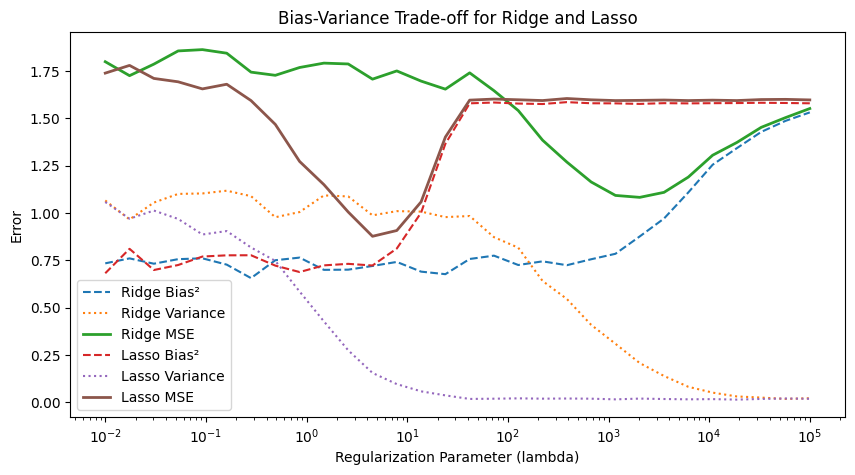

In [65]:
from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt

def generate_and_predict(alpha, model_class, X_test, training_test_size = 100):
    # Generate training data
    X_train, y_train = draw_data(n_samples=training_test_size)
    model = model_class(alpha=alpha)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def compute_metrics_for_alpha(N, alpha, model_class, X_test, y_test, iters=100):
    predictions = []
    training_test_size = N

    # repeat the procedure over different training data:
    for _ in range(iters):
        y_pred = generate_and_predict(alpha, model_class, X_test, training_test_size) 
        predictions.append(y_pred)

    predictions = np.array(predictions)
    mean_pred = np.mean(predictions, axis=0)
    assert(mean_pred.shape == y_test.shape)

    bias_2 = np.mean((mean_pred - y_test) ** 2)
    variance = np.mean(np.var(predictions, axis=0))
    mse = np.mean((predictions - y_test) ** 2)

    return bias_2, variance, mse


alpha_vals = np.logspace(-4, 3, 30)

# number of training samples,
# we have alpha = lambda / N
# so that lambda = alpha * N
N = 100
lambda_vals = alpha_vals * N

results = {"ridge": {"bias": [], "variance": [], "mse":[]}, 
           "lasso": {"bias": [], "variance": [], "mse":[]}}

for alpha in alpha_vals:
    b, v, mse = compute_metrics_for_alpha(N, alpha, Lasso, X_test, y_test)
    results["lasso"]["bias"].append(b)
    results["lasso"]["variance"].append(v)
    results["lasso"]["mse"].append(mse)

    b, v, mse = compute_metrics_for_alpha(N, alpha, Ridge, X_test, y_test)
    results["ridge"]["bias"].append(b)
    results["ridge"]["variance"].append(v)
    results["ridge"]["mse"].append(mse)



# Now plot the results:
# Plot Bias_2, Variance, and MSE
plt.figure(figsize=(10, 5))

for model_type in ["ridge", "lasso"]:
    data = results[model_type]
    
    plt.plot(lambda_vals, data["bias"], label=f"{model_type.capitalize()} Bias²", linestyle="dashed")
    plt.plot(lambda_vals, data["variance"], label=f"{model_type.capitalize()} Variance", linestyle="dotted")
    plt.plot(lambda_vals, data["mse"], label=f"{model_type.capitalize()} MSE", linewidth=2)


plt.xscale("log")
plt.xlabel("Regularization Parameter (lambda)")
plt.ylabel("Error")
plt.title("Bias-Variance Trade-off for Ridge and Lasso")
plt.legend()
plt.show()


# Conclusions

## MSE decomposition into Variance and Bias
### Derivation (after https://people.eecs.berkeley.edu/~jrs/189s19/lec/12.pdf)

Let's assume that $y_i = f(x_i) + \epsilon_i$ where $\epsilon_i\stackrel{iid}{\sim}\mathcal{N}(0,1)$

Let's assume that we've fit the linear regression model $h$ (it is a random variable determined by training data)

For a new datapoint $z$, our prediction is $h(z)$, and actual value is $f(z) + \epsilon$
Notice that $h(z)$ is determined by training set $X$, whereas $f(z) + \epsilon$ depends on random $\epsilon$ which is independent of $X$. Hence $h(z) \bot f(z)+\epsilon$.

We now decompose the mean squared error (setting $\gamma \coloneqq f(z)+\epsilon$):

\begin{align*}
&\mathbb{E}\left[(h(z) - \gamma)^2\right] = \mathbb{E}(h(z))^2 + \mathbb{E}\gamma^2 - 2\mathbb{E}\gamma h(z)
=\\
&= Var(h(z)) + \left(\mathbb{E}h(z)\right)^2 + Var\gamma + (\mathbb{E}\gamma)^2 - 2\mathbb{E}\gamma\mathbb{E}h(z) = \\
& = \left(\mathbb{E}h(z) - \mathbb{E}\gamma\right)^2 +Var h(z) + Var\gamma = \\
& = \left(\mathbb{E}h(z) - \mathbb{E}(f(z)+\epsilon)\right)^2 +Var h(z) + Var(f(z)+\epsilon) = \\
& = \left(\mathbb{E}h(z) - f(z)\right)^2 + Var h(z) + Var\epsilon = \\
& = Bias^2 + Variance + Irreducible Error
\end{align*}


## Plot analysis
The expected outcome (increasing bias, decreasing variance, U-shaped MSE) has been achieved for both Lasso and Ridge. For the given dataset (only a few non-zero coefficients), we see that Lasso achieves lover optimal MSE for smaller $\lambda$ value. That is because Lasso sets many coefficients to zero, simplifying the model rapidly.
For Ridge model, the variance decreases more steadily, because this model doesn't set coefficients to 0 but makes them smaller

Lasso has more advantage in situations where the features are sparse (only a couple non-zero betas).
Whereas if features would be collinear, then Ridge would shrink the features together instead of picking one and zeroing the others, which can be an advantage against Lasso.